Model - (1) Update Training
Randomly "drop" 10–20% of satellites at every step during training

Satellite embeddings set to zero (masked)

Also mask visibility edges (sat -> gateway, sat -> cell)

(2) Update Testing
Allow satellites to disappear and reappear

Maintain memory only for persisting satellites

If a satellite wasn't seen last timestep, initialize its memory randomly (newcomer)

(3) Improve the Evaluation
Track coverage over time

Check how many gateways + cells are covered despite dynamic satellite changes

Plot graphs: % cell coverage vs time, % gateway coverage vs time



In [ ]:
# === Imports ===
import os
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

from src.dataloader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayCellGNN
from src.train2 import train_until_converged

# === `Paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

# === Normalize function ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === Helper: Binning satellites ===
def get_bin_key(lat, lon, bin_size=1.0):
    return (round(lat / bin_size), round(lon / bin_size))

# === Snapshot files ===
all_snapshot_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
snapshot_files = all_snapshot_files[:10]  # Always the first 10 snapshots for consistent learning

# === Model State ===
hidden_dim = 64
model = None
optimizer = None
memory_dict = {}
bin_size = 1.0

# === Training across snapshots ===
for idx, file in enumerate(snapshot_files):
    print(f"\nTraining on snapshot {idx+1}/{len(snapshot_files)}: {file}")

    satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=file)
    data, visibility_matrices = build_hetero_graph(satellites, gateways, cells, timestep=idx)

    # Normalize features
    for node_type in ['sat', 'gateway', 'cell']:
        data[node_type].x = normalize(data[node_type].x)

    # Extract satellite positions
    sat_lat = [sat['latitude'] for sat in satellites]
    sat_lon = [sat['longitude'] for sat in satellites]
    sat_positions = list(zip(sat_lat, sat_lon))

    # Demand vector
    cell_demands = data['cell'].x[:, -2].unsqueeze(1)

    # Auxiliary inputs
    aux_inputs = {
        'sat_gateway': visibility_matrices['sat_gateway'],
        'sat_cell': visibility_matrices['sat_cell'],
        'cell_sat': visibility_matrices['cell_sat'],
        'cell_demands': cell_demands
    }

    # Loss weights (updated for better coverage)
    loss_weights = {
        'alpha': 20.0,   # gateway coverage
        'beta': 2.0,     # satellite to gateway assignment regularization
        'delta': 30.0,   # cell coverage — INCREASE THIS
        'zeta': 0.1,     # satellite capacity
        'eta': 0.01,      # optional satellite-to-cell exclusivity
        'gamma': 5.0     # gateway exclusivity
    }


    # Initialize model
    if model is None:
        input_dims = {
            'sat': data['sat'].x.shape[1],
            'gateway': data['gateway'].x.shape[1],
            'cell': data['cell'].x.shape[1]
        }
        model = SatGatewayCellGNN(hidden_dim, num_gateways=data['gateway'].num_nodes, num_cells=data['cell'].num_nodes, input_dims=input_dims)
        optimizer = optim.Adam(model.parameters(), lr=0.0005)  # smaller learning rate

    # Train
    model, history, final_outputs = train_until_converged(
        model=model,
        data=data,
        optimizer=optimizer,
        aux_inputs=aux_inputs,
        loss_weights=loss_weights,
        epochs=50,            # More epochs to let it converge fully
        patience=7,           # Slightly more patience
        verbose=True,
        return_probs=True,
        memory_dict=memory_dict,
        sat_positions=sat_positions,
        bin_size=bin_size,
        satellite_masking_prob=0.9,  # Less aggressive masking
        drop_prob=0.15               # Less satellite dropout
    )

# Save model
torch.save(model.state_dict(), "trained_sat_gateway_model_multi.pt")
print("\nModel saved as 'trained_sat_gateway_model_multi.pt'")

# Plot coverage
plt.plot([x * 100 for x in history['gateway_coverage']], label='Gateway Coverage (%)')
plt.plot([x * 100 for x in history['cell_coverage']], label='Cell Coverage (%)')
plt.xlabel('Epoch')
plt.ylabel('Coverage (%)')
plt.title('Coverage Over Time (Last Snapshot)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-pa


Training on snapshot 1/10: file_data_00_00_00.csv
[Epoch 001] Loss: 80.1940 | GW-Coverage: 85.19% | Cell-Coverage: 100.00%
[Epoch 002] Loss: 79.8749 | GW-Coverage: 83.33% | Cell-Coverage: 100.00%
[Epoch 003] Loss: 79.4479 | GW-Coverage: 85.19% | Cell-Coverage: 100.00%
[Epoch 004] Loss: 79.0958 | GW-Coverage: 83.33% | Cell-Coverage: 100.00%
[Epoch 005] Loss: 78.7139 | GW-Coverage: 87.04% | Cell-Coverage: 100.00%
[Epoch 006] Loss: 78.3207 | GW-Coverage: 87.04% | Cell-Coverage: 100.00%
[Epoch 007] Loss: 77.8906 | GW-Coverage: 88.89% | Cell-Coverage: 100.00%
[Epoch 008] Loss: 77.4264 | GW-Coverage: 92.59% | Cell-Coverage: 100.00%
[Epoch 009] Loss: 76.9476 | GW-Coverage: 88.89% | Cell-Coverage: 100.00%
[Epoch 010] Loss: 76.4420 | GW-Coverage: 94.44% | Cell-Coverage: 100.00%
[Epoch 011] Loss: 75.9545 | GW-Coverage: 92.59% | Cell-Coverage: 100.00%
[Epoch 012] Loss: 75.4060 | GW-Coverage: 94.44% | Cell-Coverage: 100.00%
[Epoch 013] Loss: 74.8352 | GW-Coverage: 92.59% | Cell-Coverage: 100.00%


KeyboardInterrupt: 

In [3]:
# === Imports ===
import os
import torch
import pandas as pd
from collections import defaultdict

from src.dataloader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayCellGNN

# === Paths ===
model_path = "trained_sat_gateway_model_multi.pt"
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

# === Settings ===
hidden_dim = 64
cell_threshold = 0.02
bin_size = 1.0

# === Helper ===
def get_bin_key(lat, lon, bin_size=1.0):
    return (round(lat / bin_size), round(lon / bin_size))

# === Load files ===
snapshot_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
files_to_test = snapshot_files[:10]  # 5 mins = 15 snapshots (assuming 20 secs each)

# === Load Model ===
# Dummy to get dimensions
dummy_sats, dummy_gws, dummy_cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=files_to_test[0])
dummy_data, dummy_aux = build_hetero_graph(dummy_sats, dummy_gws, dummy_cells, timestep=0)

input_dims = {
    'sat': dummy_data['sat'].x.shape[1],
    'gateway': dummy_data['gateway'].x.shape[1],
    'cell': dummy_data['cell'].x.shape[1],
}
num_gws = dummy_data['gateway'].num_nodes
num_cells = dummy_data['cell'].num_nodes

model = SatGatewayCellGNN(hidden_dim, num_gateways=num_gws, num_cells=num_cells, input_dims=input_dims)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# === Memory initialization ===
memory_dict = {}
sat_memory = None

# === Results for later plotting ===
gateway_coverage_list = []
cell_coverage_list = []

# === Testing loop ===
# === Testing loop with detailed output ===
for timestep, file in enumerate(files_to_test):
    print(f"\n=== Evaluating timestep {timestep} | file: {file} ===")

    satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=file)
    data, aux_inputs = build_hetero_graph(satellites, gateways, cells, timestep=timestep)

    num_sats = data['sat'].num_nodes
    num_gws = data['gateway'].num_nodes
    num_cells = data['cell'].num_nodes

    # Build visibility matrices
    sat_gateway = torch.zeros((num_sats, num_gws))
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        sat_gateway[src, dst] = 1

    sat_cell = torch.zeros((num_sats, num_cells))
    gw_to_sats = defaultdict(list)
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        gw_to_sats[dst.item()].append(src.item())

    for gw, cell in data['gateway', 'serves', 'cell'].edge_index.t():
        for sat in gw_to_sats[gw.item()]:
            sat_cell[sat, cell.item()] = 1

    # Satellite memory
    sat_lat = [sat['latitude'] for sat in satellites]
    sat_lon = [sat['longitude'] for sat in satellites]
    sat_ids = [sat['sat_id'] for sat in satellites]

    sat_memory_input = torch.zeros(num_sats, hidden_dim)
    for i, (lat, lon, sat_id) in enumerate(zip(sat_lat, sat_lon, sat_ids)):
        bin_key = get_bin_key(lat, lon, bin_size)
        if sat_id in memory_dict:
            sat_memory_input[i] = memory_dict[sat_id]
        elif bin_key in memory_dict:
            sat_memory_input[i] = memory_dict[bin_key]
        else:
            sat_memory_input[i] = torch.zeros(hidden_dim)

    # Run inference
    with torch.no_grad():
        outputs = model(data, visibility_matrices={
            'sat_gateway': sat_gateway,
            'sat_cell': sat_cell,
            'cell_sat': torch.zeros((num_cells, num_sats))
        }, sat_memory=sat_memory_input)

    sat_memory_out = outputs['sat_memory_out'].detach()
    for sat_id, mem in zip(sat_ids, sat_memory_out):
        memory_dict[sat_id] = mem

    gateway_probs = outputs['sat_gateway_probs']
    cell_probs = outputs['sat_cell_probs']

    # Generate predictions
    gateway_preds = torch.argmax(gateway_probs, dim=1)

    timestep_results = []
    for sat_idx, sat_id in enumerate(sat_ids):
        visible_mask = sat_cell[sat_idx] > 0
        assigned_mask = cell_probs[sat_idx] > cell_threshold
        covered_cells = torch.where(visible_mask & assigned_mask)[0].tolist()

        timestep_results.append({
            'satellite_id': sat_id,
            'predicted_gateway': gateway_preds[sat_idx].item(),
            'covered_cells': covered_cells
        })

    timestep_df = pd.DataFrame(timestep_results)
    print(timestep_df)

    # Coverage stats
    unique_gateways = gateway_preds.unique()
    covered_cells_all = set(cell for row in timestep_results for cell in row['covered_cells'])

    cell_coverage = len(covered_cells_all) / num_cells
    gw_coverage = len(unique_gateways) / num_gws

    gateway_coverage_list.append(gw_coverage)
    cell_coverage_list.append(cell_coverage)

    print(f" Gateway coverage: {gw_coverage*100:.2f}%")
    print(f" Cell coverage: {cell_coverage*100:.2f}%")


# === Summary ===
print("\n==== Summary over time ====")
for t in range(len(gateway_coverage_list)):
    print(f"Timestep {t:02d}: GW-Coverage {gateway_coverage_list[t]*100:.2f}%, Cell-Coverage {cell_coverage_list[t]*100:.2f}%")

# === Optional: Save results to CSV ===
results_df = pd.DataFrame({
    "timestep": list(range(len(gateway_coverage_list))),
    "gateway_coverage": [x * 100 for x in gateway_coverage_list],
    "cell_coverage": [x * 100 for x in cell_coverage_list]
})
results_df.to_csv("test_results.csv", index=False)
print("\nSaved coverage results to 'test_results.csv'")



=== Evaluating timestep 0 | file: file_data_00_00_00.csv ===
     satellite_id  predicted_gateway  \
0            1479                 36   
1              30                 50   
2             188                 12   
3             189                 33   
4            1434                 36   
..            ...                ...   
107           325                 10   
108          1455                 11   
109           257                 33   
110          1569                 12   
111            51                  3   

                                         covered_cells  
0    [0, 1, 4, 5, 7, 10, 11, 12, 13, 18, 19, 21, 25...  
1    [1, 3, 7, 9, 10, 13, 17, 20, 21, 24, 27, 28, 2...  
2    [2, 6, 9, 11, 14, 15, 16, 17, 22, 23, 30, 31, ...  
3    [3, 9, 10, 14, 15, 17, 28, 30, 31, 35, 38, 43,...  
4    [0, 4, 5, 12, 18, 21, 25, 27, 44, 46, 50, 51, ...  
..                                                 ...  
107  [0, 2, 3, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17,...  
1

Test 4 neigh sat - graph

Training on 10 continuous files 

c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-pa


Training on snapshot 1/10: file_data_00_00_00.csv
[Epoch 001] Loss: 1344.9542 | GW-Coverage: 85.19% | Cell-Coverage: 100.00%
[Epoch 002] Loss: 1339.7687 | GW-Coverage: 83.33% | Cell-Coverage: 100.00%
[Epoch 003] Loss: 1334.5341 | GW-Coverage: 85.19% | Cell-Coverage: 100.00%
[Epoch 004] Loss: 1328.8710 | GW-Coverage: 83.33% | Cell-Coverage: 100.00%
[Epoch 005] Loss: 1322.7882 | GW-Coverage: 85.19% | Cell-Coverage: 100.00%
[Epoch 006] Loss: 1315.4121 | GW-Coverage: 87.04% | Cell-Coverage: 100.00%
[Epoch 007] Loss: 1307.9358 | GW-Coverage: 88.89% | Cell-Coverage: 100.00%
[Epoch 008] Loss: 1300.3900 | GW-Coverage: 88.89% | Cell-Coverage: 100.00%
[Epoch 009] Loss: 1291.9279 | GW-Coverage: 87.04% | Cell-Coverage: 100.00%
[Epoch 010] Loss: 1283.0201 | GW-Coverage: 87.04% | Cell-Coverage: 100.00%
[Epoch 011] Loss: 1271.4301 | GW-Coverage: 87.04% | Cell-Coverage: 100.00%
[Epoch 012] Loss: 1260.4041 | GW-Coverage: 87.04% | Cell-Coverage: 100.00%
[Epoch 013] Loss: 1249.8992 | GW-Coverage: 87.04%

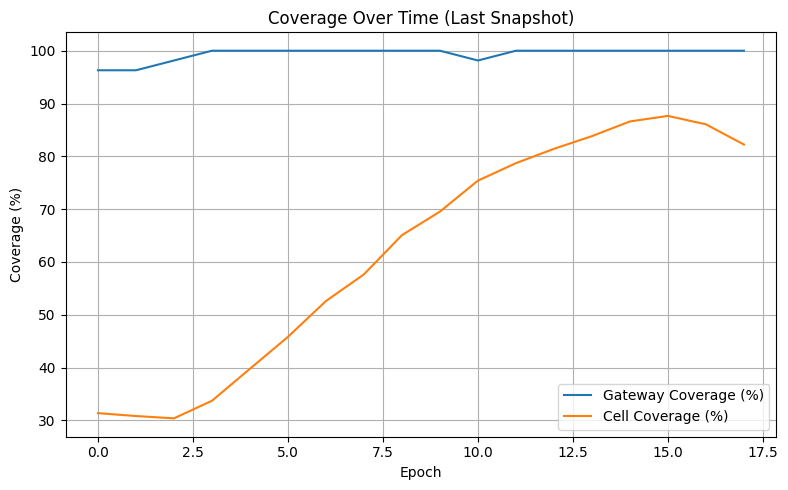

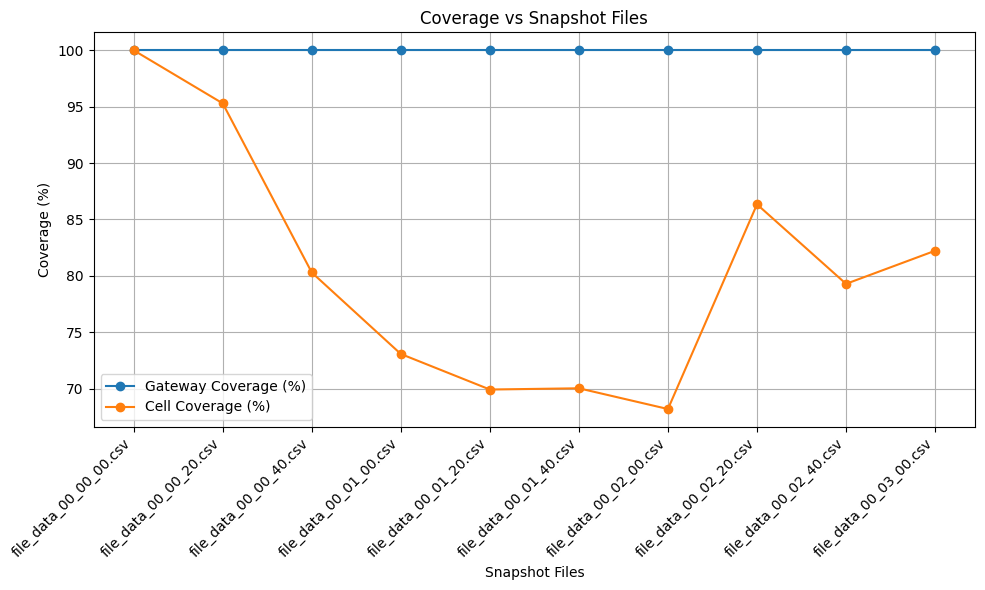


Now plotting structured satellite network...


C:\Users\aruna\AppData\Local\Temp\ipykernel_33496\1841355876.py:186: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aruna\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


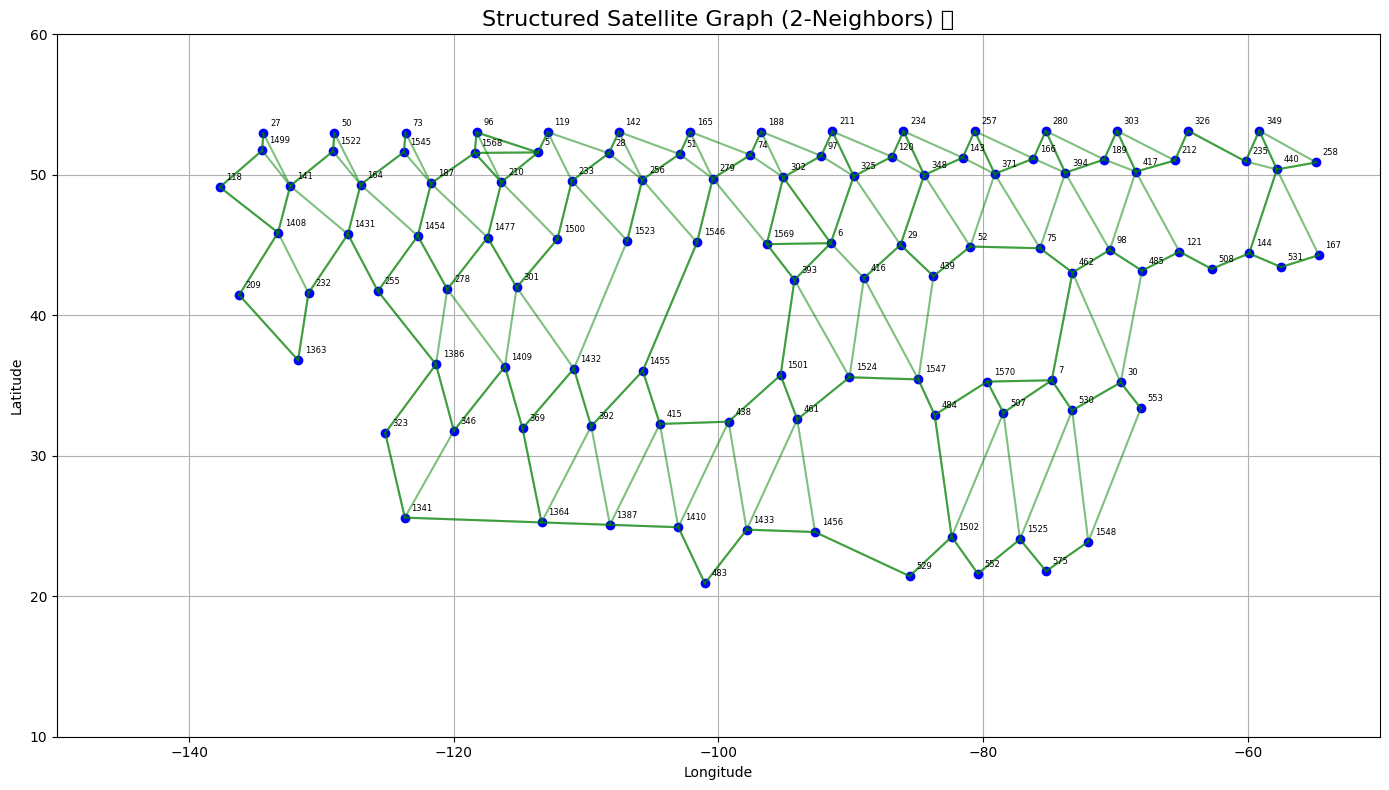

In [ ]:
# === Imports ===
import os
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

from src.dataloader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayCellGNN
from src.train2 import train_until_converged

# === Paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

# === Normalize function ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === Helper: Binning satellites ===
def get_bin_key(lat, lon, bin_size=1.0):
    return (round(lat / bin_size), round(lon / bin_size))

# === Snapshot files ===
all_snapshot_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
snapshot_files = all_snapshot_files[:10]  # Use the first 10 snapshots

# === Model State ===
hidden_dim = 64
model = None
optimizer = None
memory_dict = {}
bin_size = 1.0

# === Store final coverage results ===
gateway_coverage_list = []
cell_coverage_list = []

# === Training across snapshots ===
for idx, file in enumerate(snapshot_files):
    print(f"\nTraining on snapshot {idx+1}/{len(snapshot_files)}: {file}")

    satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=file)
    data, visibility_matrices = build_hetero_graph(
        satellites, gateways, cells, timestep=idx, structured_neighbors=True  # <== Use structured neighbors
    )

    # Normalize features
    for node_type in ['sat', 'gateway', 'cell']:
        data[node_type].x = normalize(data[node_type].x)

    # Extract satellite positions
    sat_lat = [sat['latitude'] for sat in satellites]
    sat_lon = [sat['longitude'] for sat in satellites]
    sat_positions = list(zip(sat_lat, sat_lon))

    # Demand vector
    cell_demands = data['cell'].x[:, -2].unsqueeze(1)

    # Auxiliary inputs
    aux_inputs = {
        'sat_gateway': visibility_matrices['sat_gateway'],
        'sat_cell': visibility_matrices['sat_cell'],
        'cell_sat': visibility_matrices['cell_sat'],
        'cell_demands': cell_demands
    }

    # Loss weights
    loss_weights = {
        'alpha': 20.0,  # gateway coverage
        'beta': 2.0,    # satellite-gateway regularization
        'delta': 300.0,  # cell coverage
        'zeta': 0.1,    # satellite capacity
        'eta': 2.0,    # satellite-cell exclusivity
        'gamma': 20.0    # gateway exclusivity
    }

    # Initialize model
    if model is None:
        input_dims = {
            'sat': data['sat'].x.shape[1],
            'gateway': data['gateway'].x.shape[1],
            'cell': data['cell'].x.shape[1]
        }
        model = SatGatewayCellGNN(hidden_dim, num_gateways=data['gateway'].num_nodes, num_cells=data['cell'].num_nodes, input_dims=input_dims)
        optimizer = optim.Adam(model.parameters(), lr=0.0005)

    # Train
    model, history, final_outputs = train_until_converged(
        model=model,
        data=data,
        optimizer=optimizer,
        aux_inputs=aux_inputs,
        loss_weights=loss_weights,
        epochs=50,
        patience=7,
        verbose=True,
        return_probs=True,
        memory_dict=memory_dict,
        sat_positions=sat_positions,
        bin_size=bin_size,
        satellite_masking_prob=0.9,
        drop_prob=0.15
    )

    # Save final coverage for this snapshot
    gateway_coverage_list.append(history['gateway_coverage'][-1])
    cell_coverage_list.append(history['cell_coverage'][-1])

# === Save model ===
torch.save(model.state_dict(), "trained_sat_gateway_model_multi.pt")
print("\n Model saved as 'trained_sat_gateway_model_multi.pt'")

# === Plot 1: Training Coverage Over Epochs for Last Snapshot ===
plt.figure(figsize=(8, 5))
plt.plot([x * 100 for x in history['gateway_coverage']], label='Gateway Coverage (%)')
plt.plot([x * 100 for x in history['cell_coverage']], label='Cell Coverage (%)')
plt.xlabel('Epoch')
plt.ylabel('Coverage (%)')
plt.title('Coverage Over Time (Last Snapshot)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 2: Final Coverage across Snapshots ===
gateway_coverage_percent = [x * 100 for x in gateway_coverage_list]
cell_coverage_percent = [x * 100 for x in cell_coverage_list]

plt.figure(figsize=(10, 6))
plt.plot(snapshot_files, gateway_coverage_percent, label='Gateway Coverage (%)', marker='o')
plt.plot(snapshot_files, cell_coverage_percent, label='Cell Coverage (%)', marker='o')

plt.xticks(rotation=45, ha='right')  # Rotate x labels
plt.xlabel('Snapshot Files')
plt.ylabel('Coverage (%)')
plt.title('Coverage vs Snapshot Files')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 3: Structured Satellite Network ===
print("\nNow plotting structured satellite network...")

# Build mapping
idx_to_pos = {idx: (sat['latitude'], sat['longitude']) for idx, sat in enumerate(satellites)}
idx_to_satid = {idx: sat['sat_id'] for idx, sat in enumerate(satellites)}

# Build connections dictionary
connections = {}
edge_index = data['sat', 'connected_to', 'sat'].edge_index
for src_idx, dst_idx in edge_index.t().tolist():
    if src_idx not in connections:
        connections[src_idx] = []
    connections[src_idx].append(dst_idx)

# Remove duplicate neighbors
for src_idx in connections:
    connections[src_idx] = list(set(connections[src_idx]))

# Plot
plt.figure(figsize=(14, 8))
plt.title("Structured Satellite Graph (2-Neighbors) 🌍", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# Plot satellites
for idx, (lat, lon) in idx_to_pos.items():
    plt.plot(lon, lat, 'bo')
    plt.text(lon + 0.5, lat + 0.5, str(idx_to_satid[idx]), fontsize=6, color='black')

# Plot edges
for src_idx, dst_list in connections.items():
    for dst_idx in dst_list:
        lat_src, lon_src = idx_to_pos[src_idx]
        lat_dst, lon_dst = idx_to_pos[dst_idx]
        plt.plot([lon_src, lon_dst], [lat_src, lat_dst], 'g-', alpha=0.5)

plt.xlim(-150, -50)
plt.ylim(10, 60)
plt.tight_layout()
plt.show()


Testing based on 10 cont files

In [2]:
# === Imports ===
import os
import torch
import pandas as pd
from collections import defaultdict

from src.dataloader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayCellGNN

# === Paths ===
model_path = "trained_sat_gateway_model_multi.pt"
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

# === Settings ===
hidden_dim = 64
cell_threshold = 0.02
bin_size = 1.0

# === Helper ===
def get_bin_key(lat, lon, bin_size=1.0):
    return (round(lat / bin_size), round(lon / bin_size))

# === Load files ===
snapshot_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
files_to_test = snapshot_files[:10]  # Use 10 files

# === Load Model ===
# Dummy for dimension inference
dummy_sats, dummy_gws, dummy_cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=files_to_test[0])
dummy_data, dummy_aux = build_hetero_graph(dummy_sats, dummy_gws, dummy_cells, timestep=0, structured_neighbors=True)

input_dims = {
    'sat': dummy_data['sat'].x.shape[1],
    'gateway': dummy_data['gateway'].x.shape[1],
    'cell': dummy_data['cell'].x.shape[1],
}
num_gws = dummy_data['gateway'].num_nodes
num_cells = dummy_data['cell'].num_nodes

model = SatGatewayCellGNN(hidden_dim, num_gateways=num_gws, num_cells=num_cells, input_dims=input_dims)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# === Memory initialization ===
memory_dict = {}
sat_memory = None

# === Results for plotting ===
gateway_coverage_list = []
cell_coverage_list = []

# === Testing loop ===
for timestep, file in enumerate(files_to_test):
    print(f"\n=== Evaluating timestep {timestep} | file: {file} ===")

    satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=file)
    data, aux_inputs = build_hetero_graph(satellites, gateways, cells, timestep=timestep, structured_neighbors=True)

    num_sats = data['sat'].num_nodes
    num_gws = data['gateway'].num_nodes
    num_cells = data['cell'].num_nodes

    # Build visibility matrices
    sat_gateway = torch.zeros((num_sats, num_gws))
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        sat_gateway[src, dst] = 1

    sat_cell = torch.zeros((num_sats, num_cells))
    gw_to_sats = defaultdict(list)
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        gw_to_sats[dst.item()].append(src.item())

    for gw, cell in data['gateway', 'serves', 'cell'].edge_index.t():
        for sat in gw_to_sats[gw.item()]:
            sat_cell[sat, cell.item()] = 1

    # Satellite memory
    sat_lat = [sat['latitude'] for sat in satellites]
    sat_lon = [sat['longitude'] for sat in satellites]
    sat_ids = [sat['sat_id'] for sat in satellites]

    sat_memory_input = torch.zeros(num_sats, hidden_dim)
    for i, (lat, lon, sat_id) in enumerate(zip(sat_lat, sat_lon, sat_ids)):
        bin_key = get_bin_key(lat, lon, bin_size)
        if sat_id in memory_dict:
            sat_memory_input[i] = memory_dict[sat_id]
        elif bin_key in memory_dict:
            sat_memory_input[i] = memory_dict[bin_key]
        else:
            sat_memory_input[i] = torch.zeros(hidden_dim)

    # Run inference
    with torch.no_grad():
        outputs = model(data, visibility_matrices={
            'sat_gateway': sat_gateway,
            'sat_cell': sat_cell,
            'cell_sat': torch.zeros((num_cells, num_sats))
        }, sat_memory=sat_memory_input)

    sat_memory_out = outputs['sat_memory_out'].detach()
    for sat_id, mem in zip(sat_ids, sat_memory_out):
        memory_dict[sat_id] = mem

    gateway_probs = outputs['sat_gateway_probs']
    cell_probs = outputs['sat_cell_probs']

    # === Extract cell demands ===
    cell_demands = data['cell'].x[:, -2]  # Assuming 2nd last feature is "demand" 🔥

    # === Generate predictions ===
    gateway_preds = torch.argmax(gateway_probs, dim=1)

    timestep_results = []
    for sat_idx, sat_id in enumerate(sat_ids):
        visible_mask = sat_cell[sat_idx] > 0
        assigned_mask = cell_probs[sat_idx] > cell_threshold
        covered_cells = torch.where(visible_mask & assigned_mask)[0].tolist()

        # NEW: Sum total demand for covered cells
        total_demand = cell_demands[covered_cells].sum().item() if covered_cells else 0.0

        timestep_results.append({
            'satellite_id': sat_id,
            'predicted_gateway': gateway_preds[sat_idx].item(),
            'covered_cells': covered_cells,
            'total_demand': total_demand   # 🔥 added here
        })

    timestep_df = pd.DataFrame(timestep_results)
    print(timestep_df)

    # Coverage stats
    unique_gateways = gateway_preds.unique()
    covered_cells_all = set(cell for row in timestep_results for cell in row['covered_cells'])

    cell_coverage = len(covered_cells_all) / num_cells
    gw_coverage = len(unique_gateways) / num_gws

    gateway_coverage_list.append(gw_coverage)
    cell_coverage_list.append(cell_coverage)

    print(f" Gateway coverage: {gw_coverage*100:.2f}%")
    print(f" Cell coverage: {cell_coverage*100:.2f}%")

# === Summary ===
print("\n==== Summary over time ====")
for t in range(len(gateway_coverage_list)):
    print(f"Timestep {t:02d}: GW-Coverage {gateway_coverage_list[t]*100:.2f}%, Cell-Coverage {cell_coverage_list[t]*100:.2f}%")

# === Optional: Save results to CSV ===
results_df = pd.DataFrame({
    "timestep": list(range(len(gateway_coverage_list))),
    "gateway_coverage": [x * 100 for x in gateway_coverage_list],
    "cell_coverage": [x * 100 for x in cell_coverage_list]
})
results_df.to_csv("test_results.csv", index=False)
print("\n Saved coverage results to 'test_results.csv'")



=== Evaluating timestep 0 | file: file_data_00_00_00.csv ===
     satellite_id  predicted_gateway  \
0            1479                 45   
1              30                 50   
2             188                 12   
3             189                 33   
4            1434                 32   
..            ...                ...   
107           325                 22   
108          1455                 11   
109           257                 33   
110          1569                 12   
111            51                  7   

                                         covered_cells  total_demand  
0    [0, 1, 4, 5, 7, 10, 11, 12, 13, 18, 19, 21, 25...  48027.742188  
1    [1, 3, 7, 9, 10, 13, 17, 20, 21, 24, 27, 28, 2...  37534.226562  
2    [2, 6, 9, 11, 14, 15, 16, 17, 22, 23, 30, 31, ...  30578.289062  
3    [3, 9, 10, 14, 15, 17, 28, 30, 31, 35, 38, 43,...  17819.906250  
4    [0, 4, 5, 12, 18, 21, 25, 27, 44, 46, 50, 51, ...  16745.054688  
..                             


=== Evaluating timestep 0 | file: file_data_00_00_00.csv ===
 Gateway coverage: 53.70%
 Cell coverage: 100.00%


KeyError: 'longitude'

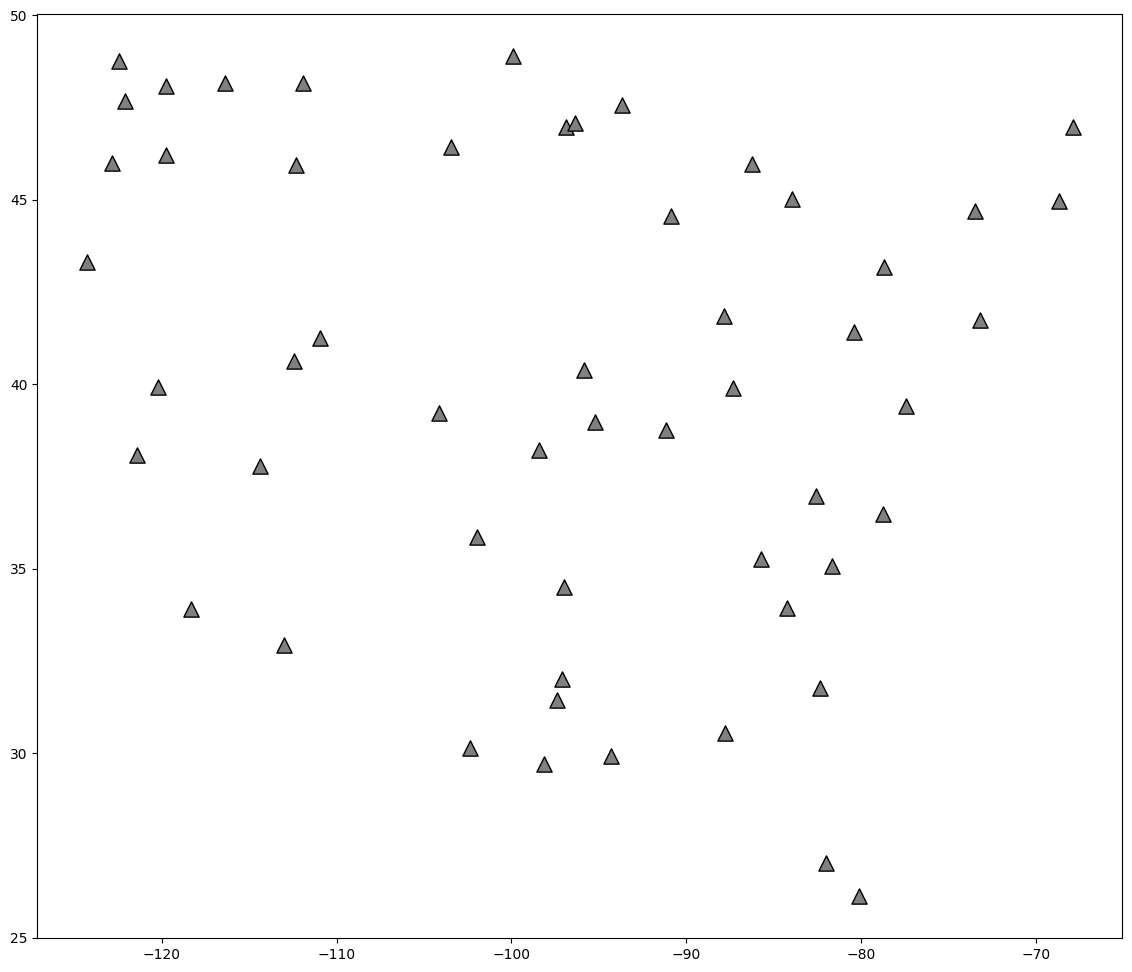

In [9]:
import os
import torch
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

from src.dataloader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayCellGNN

# === Paths ===
model_path = "trained_sat_gateway_model_multi.pt"
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

gw_df = pd.read_csv(gateway_file)
cells_df = pd.read_csv(cell_file)

def lighten_color(color, factor=0.4):
    color_rgb = np.array(mcolors.to_rgb(color))
    return mcolors.to_hex(np.clip(color_rgb + factor * (1 - color_rgb), 0, 1))

MAX_CELLS_PER_SAT = 50
# === Settings ===
hidden_dim = 64
cell_threshold = 0.02
bin_size = 1.0

# === Helper ===
def get_bin_key(lat, lon, bin_size=1.0):
    return (round(lat / bin_size), round(lon / bin_size))

# === Load files ===
snapshot_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
files_to_test = snapshot_files[:10]  # Use 10 files

# === Load Model ===
# Dummy for dimension inference
dummy_sats, dummy_gws, dummy_cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=files_to_test[0])
dummy_data, dummy_aux = build_hetero_graph(dummy_sats, dummy_gws, dummy_cells, timestep=0, structured_neighbors=True)

input_dims = {
    'sat': dummy_data['sat'].x.shape[1],
    'gateway': dummy_data['gateway'].x.shape[1],
    'cell': dummy_data['cell'].x.shape[1],
}
num_gws = dummy_data['gateway'].num_nodes
num_cells = dummy_data['cell'].num_nodes

model = SatGatewayCellGNN(hidden_dim, num_gateways=num_gws, num_cells=num_cells, input_dims=input_dims)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# === Memory initialization ===
memory_dict = {}
sat_memory = None

# === Results for plotting ===
gateway_coverage_list = []
cell_coverage_list = []

# === Testing loop ===
for timestep, file in enumerate(files_to_test):
    print(f"\n=== Evaluating timestep {timestep} | file: {file} ===")

    satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=file)
    data, aux_inputs = build_hetero_graph(satellites, gateways, cells, timestep=timestep, structured_neighbors=True)

    num_sats = data['sat'].num_nodes
    num_gws = data['gateway'].num_nodes
    num_cells = data['cell'].num_nodes

    # Build visibility matrices
    sat_gateway = torch.zeros((num_sats, num_gws))
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        sat_gateway[src, dst] = 1

    sat_cell = torch.zeros((num_sats, num_cells))
    gw_to_sats = defaultdict(list)
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        gw_to_sats[dst.item()].append(src.item())

    for gw, cell in data['gateway', 'serves', 'cell'].edge_index.t():
        for sat in gw_to_sats[gw.item()]:
            sat_cell[sat, cell.item()] = 1

    # Satellite memory
    sat_lat = [sat['latitude'] for sat in satellites]
    sat_lon = [sat['longitude'] for sat in satellites]
    sat_ids = [sat['sat_id'] for sat in satellites]

    sat_memory_input = torch.zeros(num_sats, hidden_dim)
    for i, (lat, lon, sat_id) in enumerate(zip(sat_lat, sat_lon, sat_ids)):
        bin_key = get_bin_key(lat, lon, bin_size)
        if sat_id in memory_dict:
            sat_memory_input[i] = memory_dict[sat_id]
        elif bin_key in memory_dict:
            sat_memory_input[i] = memory_dict[bin_key]
        else:
            sat_memory_input[i] = torch.zeros(hidden_dim)

    # Run inference
    with torch.no_grad():
        outputs = model(data, visibility_matrices={
            'sat_gateway': sat_gateway,
            'sat_cell': sat_cell,
            'cell_sat': torch.zeros((num_cells, num_sats))
        }, sat_memory=sat_memory_input)

    sat_memory_out = outputs['sat_memory_out'].detach()
    for sat_id, mem in zip(sat_ids, sat_memory_out):
        memory_dict[sat_id] = mem

    gateway_probs = outputs['sat_gateway_probs']
    cell_probs = outputs['sat_cell_probs']

    # === Extract cell demands ===
    cell_demands = data['cell'].x[:, -2]  # Assuming 2nd last feature is "demand" 🔥

    # === Generate predictions ===
    gateway_preds = torch.argmax(gateway_probs, dim=1)

    timestep_results = []
    for sat_idx, sat_id in enumerate(sat_ids):
        visible_mask = sat_cell[sat_idx] > 0
        assigned_mask = cell_probs[sat_idx] > cell_threshold
        covered_cells = torch.where(visible_mask & assigned_mask)[0].tolist()

        # NEW: Sum total demand for covered cells
        total_demand = cell_demands[covered_cells].sum().item() if covered_cells else 0.0

        timestep_results.append({
            'satellite_id': sat_id,
            'predicted_gateway': gateway_preds[sat_idx].item(),
            'covered_cells': covered_cells,
            'total_demand': total_demand   # 🔥 added here
        })

    timestep_df = pd.DataFrame(timestep_results)

    # Coverage stats
    unique_gateways = gateway_preds.unique()
    covered_cells_all = set(cell for row in timestep_results for cell in row['covered_cells'])

    cell_coverage = len(covered_cells_all) / num_cells
    gw_coverage = len(unique_gateways) / num_gws

    gateway_coverage_list.append(gw_coverage)
    cell_coverage_list.append(cell_coverage)

    print(f" Gateway coverage: {gw_coverage*100:.2f}%")
    print(f" Cell coverage: {cell_coverage*100:.2f}%")

    # === Plotting ===
    # Plot Gateways and Satellites for this timestep
    plt.figure(figsize=(14, 12))

    # Plot Gateways
    for _, row in gw_df.iterrows():
        plt.scatter(row['longitude'], row['latitude'], marker='^', color='gray', edgecolor='black', s=120, label='Gateway' if _ == 0 else "")

    # Plot Satellites and their covered cells
    color_list = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
    np.random.seed(42)
    np.random.shuffle(color_list)
    sat_color_map = {i: color_list[i % len(color_list)] for i in range(len(timestep_df))}

    for idx, row in timestep_df.iterrows():
        sat_color = sat_color_map[idx]
        cell_color = lighten_color(sat_color, 0.4)

        # Plot satellite
        plt.scatter(row['longitude'], row['latitude'], marker='s', color=sat_color, edgecolor='black', s=100, label='Satellite' if idx == 0 else "")
        
        # Plot assigned gateway (same color as satellite)
        gw_row = gw_df[gw_df['gw_id'] == row['predicted_gateway']]
        if not gw_row.empty:
            plt.scatter(gw_row['longitude'], gw_row['latitude'], marker='^', color=sat_color, edgecolor='black', s=120)

        # Plot assigned cells (same color as satellite)
        cell_ids = row['covered_cells']
        if len(cell_ids) > MAX_CELLS_PER_SAT:
            cell_ids = np.random.choice(cell_ids, MAX_CELLS_PER_SAT, replace=False)
        valid_cells = cells_df.loc[cells_df.index.intersection(cell_ids)]
        plt.scatter(valid_cells['longitude'], valid_cells['latitude'], color=cell_color, s=10, alpha=0.6, label='Cell' if idx == 0 else "")

    # Final plot styling
    plt.title(f"Predicted Satellites, Gateways, and Covered Cells for Timestep {timestep}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# === Summary ===
print("\n==== Summary over time ====")
for t in range(len(gateway_coverage_list)):
    print(f"Timestep {t:02d}: GW-Coverage {gateway_coverage_list[t]*100:.2f}%, Cell-Coverage {cell_coverage_list[t]*100:.2f}%")

# === Optional: Save results to CSV ===
results_df = pd.DataFrame({
    "timestep": list(range(len(gateway_coverage_list))),
    "gateway_coverage": [x * 100 for x in gateway_coverage_list],
    "cell_coverage": [x * 100 for x in cell_coverage_list]
})
results_df.to_csv("test_results.csv", index=False)
print("\n Saved coverage results to 'test_results.csv'")


In [8]:
print("Columns in gateway dataframe:", gw_df.columns)
print("Columns in cell dataframe:", cells_df.columns)


Columns in gateway dataframe: Index(['gw_id', 'city', 'state', 'latitude', 'longitude'], dtype='object')
Columns in cell dataframe: Index(['cell_id', 'h3', 'latitude', 'longitude'], dtype='object')


In [3]:
import torch
import pandas as pd
from collections import defaultdict

# === Setup ===
model.eval()  # Make sure model is in evaluation mode

# Helper
def get_bin_key(lat, lon, bin_size=1.0):
    return (round(lat / bin_size), round(lon / bin_size))

# Load all snapshot filenames
snapshot_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])

# Memory
memory_dict = {}

# When to save
timesteps_to_save = {0, 15, 30}  # snapshot indexes
results_per_timestep = {}

# Testing loop
for timestep_idx, filename in enumerate(snapshot_files):
    if timestep_idx > 30:
        break  # We only need up to t=10min (snapshot 30)

    # Load data
    satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=filename)
    data, aux_inputs = build_hetero_graph(satellites, gateways, cells, timestep=timestep_idx, structured_neighbors=True)

    num_sats = data['sat'].num_nodes
    num_gws = data['gateway'].num_nodes
    num_cells = data['cell'].num_nodes

    # Visibility matrices
    sat_gateway = torch.zeros((num_sats, num_gws))
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        sat_gateway[src, dst] = 1

    sat_cell = torch.zeros((num_sats, num_cells))
    gw_to_sats = defaultdict(list)
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        gw_to_sats[dst.item()].append(src.item())

    for gw, cell in data['gateway', 'serves', 'cell'].edge_index.t():
        for sat in gw_to_sats[gw.item()]:
            sat_cell[sat, cell.item()] = 1

    # Satellite memory input
    sat_lat = [sat['latitude'] for sat in satellites]
    sat_lon = [sat['longitude'] for sat in satellites]
    sat_ids = [sat['sat_id'] for sat in satellites]

    sat_memory_input = torch.zeros(num_sats, hidden_dim)
    for i, (lat, lon, sat_id) in enumerate(zip(sat_lat, sat_lon, sat_ids)):
        bin_key = get_bin_key(lat, lon, bin_size)
        if sat_id in memory_dict:
            sat_memory_input[i] = memory_dict[sat_id]
        elif bin_key in memory_dict:
            sat_memory_input[i] = memory_dict[bin_key]
        else:
            sat_memory_input[i] = torch.zeros(hidden_dim)

    # Run model
    with torch.no_grad():
        outputs = model(data, visibility_matrices={
            'sat_gateway': sat_gateway,
            'sat_cell': sat_cell,
            'cell_sat': torch.zeros((num_cells, num_sats))
        }, sat_memory=sat_memory_input)

    # Update memory
    sat_memory_out = outputs['sat_memory_out'].detach()
    for sat_id, mem in zip(sat_ids, sat_memory_out):
        memory_dict[sat_id] = mem

    # Save results if in timesteps_to_save
    if timestep_idx in timesteps_to_save:
        gateway_preds = torch.argmax(outputs['sat_gateway_probs'], dim=1)
        cell_probs = outputs['sat_cell_probs']

        timestep_results = []
        for sat_idx, sat_id in enumerate(sat_ids):
            visible_mask = sat_cell[sat_idx] > 0
            assigned_mask = cell_probs[sat_idx] > 0.02  # threshold
            covered_cells = torch.where(visible_mask & assigned_mask)[0].tolist()

            # Sum total demand from selected cells
            cell_features = data['cell'].x
            selected_demand = cell_features[covered_cells, -2] if covered_cells else torch.tensor([0.0])
            total_demand = selected_demand.sum().item()

            timestep_results.append({
                'satellite_id': sat_id,
                'predicted_gateway': gateway_preds[sat_idx].item(),
                'covered_cells': covered_cells,
                'total_demand': total_demand
            })

        results_per_timestep[timestep_idx] = pd.DataFrame(timestep_results)

# === Save results ===
for timestep_idx, df in results_per_timestep.items():
    df.to_csv(f"satellite_results_timestep_{timestep_idx}.csv", index=False)
    print(f" Saved: satellite_results_timestep_{timestep_idx}.csv")


 Saved: satellite_results_timestep_0.csv
 Saved: satellite_results_timestep_15.csv
 Saved: satellite_results_timestep_30.csv


In [4]:
import pandas as pd
import ast
import pandas as pd
import ast
from collections import Counter
# === Paths to your 3 files ===
file_paths = [
    "satellite_results_timestep_0.csv",       # Change these to your actual file names
    "satellite_results_timestep_15.csv",
    "satellite_results_timestep_30.csv"
]

# === Constants ===
num_total_cells = 4569 
num_total_gateways = 54  

# === Function to calculate coverage ===
def calculate_coverage(file_path, num_cells, num_gateways):
    df = pd.read_csv(file_path)

    # covered_cells is a string of a list, so we parse it properly
    covered_cells = []
    for entry in df['covered_cells']:
        cells = ast.literal_eval(entry)  # Safely parse the list
        covered_cells.extend(cells)

    unique_cells = set(covered_cells)
    covered_cells_count = len(unique_cells)

    # Predicted gateways
    unique_gateways = df['predicted_gateway'].unique()
    covered_gateways_count = len(unique_gateways)

    # Calculate percentages
    cell_coverage = (covered_cells_count / num_cells) * 100
    gateway_coverage = (covered_gateways_count / num_gateways) * 100

    return cell_coverage, gateway_coverage

# === Run for each file ===
for path in file_paths:
    cell_cov, gw_cov = calculate_coverage(path, num_total_cells, num_total_gateways)
    print(f"\nResults for {path}:")
    print(f"  Cell Coverage: {cell_cov:.2f}%")
    print(f"  Gateway Coverage: {gw_cov:.2f}%")

# === Function to count repeated cells ===
def count_repeated_cells(file_path):
    df = pd.read_csv(file_path)

    all_cells = []
    for entry in df['covered_cells']:
        cells = ast.literal_eval(entry)
        all_cells.extend(cells)

    cell_counter = Counter(all_cells)

    repeated_cells = [cell for cell, count in cell_counter.items() if count > 1]
    num_repeated_cells = len(repeated_cells)

    return num_repeated_cells, len(cell_counter)

# === Run for each file ===
for path in file_paths:
    repeated, total_unique = count_repeated_cells(path)
    print(f"\nResults for {path}:")
    print(f"  Total Unique Cells Covered: {total_unique}")
    print(f"  Number of Repeated Cells (overlapping): {repeated}")
    print(f"  % Repeated Cells: {(repeated/total_unique)*100:.2f}%")


Results for satellite_results_timestep_0.csv:
  Cell Coverage: 100.00%
  Gateway Coverage: 53.70%

Results for satellite_results_timestep_15.csv:
  Cell Coverage: 100.00%
  Gateway Coverage: 57.41%

Results for satellite_results_timestep_30.csv:
  Cell Coverage: 100.00%
  Gateway Coverage: 57.41%

Results for satellite_results_timestep_0.csv:
  Total Unique Cells Covered: 4569
  Number of Repeated Cells (overlapping): 4569
  % Repeated Cells: 100.00%

Results for satellite_results_timestep_15.csv:
  Total Unique Cells Covered: 4569
  Number of Repeated Cells (overlapping): 4569
  % Repeated Cells: 100.00%

Results for satellite_results_timestep_30.csv:
  Total Unique Cells Covered: 4569
  Number of Repeated Cells (overlapping): 4569
  % Repeated Cells: 100.00%


In [2]:
# === Imports ===
import os
import torch
import pandas as pd
from collections import defaultdict

from src.dataloader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayCellGNN

# === Paths ===
model_path = "trained_sat_gateway_model_multi.pt"
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

# === Settings ===
hidden_dim = 64
cell_threshold = 0.02
bin_size = 1.0

# === Helper ===
def get_bin_key(lat, lon, bin_size=1.0):
    return (round(lat / bin_size), round(lon / bin_size))

# === Load files ===
snapshot_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
files_to_test = snapshot_files[:10]  # 5 mins = 15 snapshots (assuming 20 secs each)

# === Load Model ===
# Dummy to get dimensions
dummy_sats, dummy_gws, dummy_cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=files_to_test[0])
dummy_data, dummy_aux = build_hetero_graph(dummy_sats, dummy_gws, dummy_cells, timestep=0, structured_neighbors=True)

input_dims = {
    'sat': dummy_data['sat'].x.shape[1],
    'gateway': dummy_data['gateway'].x.shape[1],
    'cell': dummy_data['cell'].x.shape[1],
}
num_gws = dummy_data['gateway'].num_nodes
num_cells = dummy_data['cell'].num_nodes

model = SatGatewayCellGNN(hidden_dim, num_gateways=num_gws, num_cells=num_cells, input_dims=input_dims)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# === Memory initialization ===
memory_dict = {}
sat_memory = None

# === Results for later plotting ===
gateway_coverage_list = []
cell_coverage_list = []

# === Testing loop ===
# === Testing loop with detailed output ===
for timestep, file in enumerate(files_to_test):
    print(f"\n=== Evaluating timestep {timestep} | file: {file} ===")

    satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=file)
    data, aux_inputs = build_hetero_graph(satellites, gateways, cells, timestep=timestep, structured_neighbors=True)

    num_sats = data['sat'].num_nodes
    num_gws = data['gateway'].num_nodes
    num_cells = data['cell'].num_nodes

    # Build visibility matrices
    sat_gateway = torch.zeros((num_sats, num_gws))
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        sat_gateway[src, dst] = 1

    sat_cell = torch.zeros((num_sats, num_cells))
    gw_to_sats = defaultdict(list)
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        gw_to_sats[dst.item()].append(src.item())

    for gw, cell in data['gateway', 'serves', 'cell'].edge_index.t():
        for sat in gw_to_sats[gw.item()]:
            sat_cell[sat, cell.item()] = 1

    # Satellite memory
    sat_lat = [sat['latitude'] for sat in satellites]
    sat_lon = [sat['longitude'] for sat in satellites]
    sat_ids = [sat['sat_id'] for sat in satellites]

    sat_memory_input = torch.zeros(num_sats, hidden_dim)
    for i, (lat, lon, sat_id) in enumerate(zip(sat_lat, sat_lon, sat_ids)):
        bin_key = get_bin_key(lat, lon, bin_size)
        if sat_id in memory_dict:
            sat_memory_input[i] = memory_dict[sat_id]
        elif bin_key in memory_dict:
            sat_memory_input[i] = memory_dict[bin_key]
        else:
            sat_memory_input[i] = torch.zeros(hidden_dim)

    # Run inference
    with torch.no_grad():
        outputs = model(data, visibility_matrices={
            'sat_gateway': sat_gateway,
            'sat_cell': sat_cell,
            'cell_sat': torch.zeros((num_cells, num_sats))
        }, sat_memory=sat_memory_input)

    sat_memory_out = outputs['sat_memory_out'].detach()
    for sat_id, mem in zip(sat_ids, sat_memory_out):
        memory_dict[sat_id] = mem

    gateway_probs = outputs['sat_gateway_probs']
    cell_probs = outputs['sat_cell_probs']

    # Generate predictions
    gateway_preds = torch.argmax(gateway_probs, dim=1)

    timestep_results = []
    for sat_idx, sat_id in enumerate(sat_ids):
        visible_mask = sat_cell[sat_idx] > 0
        assigned_mask = cell_probs[sat_idx] > cell_threshold
        covered_cells = torch.where(visible_mask & assigned_mask)[0].tolist()

        timestep_results.append({
            'satellite_id': sat_id,
            'predicted_gateway': gateway_preds[sat_idx].item(),
            'covered_cells': covered_cells
        })

    timestep_df = pd.DataFrame(timestep_results)
    print(timestep_df)

    # Coverage stats
    unique_gateways = gateway_preds.unique()
    covered_cells_all = set(cell for row in timestep_results for cell in row['covered_cells'])

    cell_coverage = len(covered_cells_all) / num_cells
    gw_coverage = len(unique_gateways) / num_gws

    gateway_coverage_list.append(gw_coverage)
    cell_coverage_list.append(cell_coverage)

    print(f" Gateway coverage: {gw_coverage*100:.2f}%")
    print(f" Cell coverage: {cell_coverage*100:.2f}%")


# === Summary ===
print("\n==== Summary over time ====")
for t in range(len(gateway_coverage_list)):
    print(f"Timestep {t:02d}: GW-Coverage {gateway_coverage_list[t]*100:.2f}%, Cell-Coverage {cell_coverage_list[t]*100:.2f}%")

# === Optional: Save results to CSV ===
results_df = pd.DataFrame({
    "timestep": list(range(len(gateway_coverage_list))),
    "gateway_coverage": [x * 100 for x in gateway_coverage_list],
    "cell_coverage": [x * 100 for x in cell_coverage_list]
})
results_df.to_csv("test_results.csv", index=False)
print("\nSaved coverage results to 'test_results.csv'")



=== Evaluating timestep 0 | file: file_data_00_00_00.csv ===
     satellite_id  predicted_gateway  \
0            1479                 45   
1              30                 52   
2             188                 12   
3             189                 31   
4            1434                 17   
..            ...                ...   
107           325                 10   
108          1455                 12   
109           257                 31   
110          1569                 12   
111            51                  5   

                                         covered_cells  
0    [0, 1, 4, 5, 7, 10, 11, 12, 13, 18, 19, 21, 25...  
1    [1, 3, 7, 9, 10, 13, 17, 20, 21, 24, 27, 28, 2...  
2    [2, 6, 9, 11, 14, 15, 16, 17, 22, 23, 30, 31, ...  
3    [3, 9, 10, 14, 15, 17, 28, 30, 31, 35, 38, 43,...  
4    [0, 4, 5, 12, 18, 21, 25, 27, 44, 46, 50, 51, ...  
..                                                 ...  
107  [0, 2, 3, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17,...  
1

In [2]:
# === Imports ===
import os
import torch
from src.dataloader import load_all_data
from src.graph_builder import build_hetero_graph

# === Paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

# === Pick one snapshot file to test ===
snapshot_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
test_file = snapshot_files[0]  # take first file

print(f"Testing on snapshot: {test_file}")

# === Load data ===
satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=test_file)

# === Build graph with STRUCTURED neighbors ===
data, visibility_matrices = build_hetero_graph(
    satellites,
    gateways,
    cells,
    timestep=0,
    structured_neighbors=True  # <== IMPORTANT: Structured 4 neighbors mode
)

# === Analyze Satellite Connections ===
# === Analyze Satellite Connections (fixed version) ===
edge_index = data['sat', 'connected_to', 'sat'].edge_index

print("\n=== Satellite 4-Cross Neighbors (Structured Mode) ===")
connections = {}
sat_idx_to_id = {idx: sat['sat_id'] for idx, sat in enumerate(satellites)}

for src_idx, dst_idx in edge_index.t().tolist():
    if src_idx not in connections:
        connections[src_idx] = []
    connections[src_idx].append(dst_idx)

# Fix duplicates
for src_idx in connections:
    connections[src_idx] = list(set(connections[src_idx]))

# Print properly
for src_idx in sorted(connections.keys()):
    true_sat_id = sat_idx_to_id[src_idx]
    true_neighbors = [sat_idx_to_id[dst_idx] for dst_idx in connections[src_idx]]
    print(f"Satellite {true_sat_id} has {len(true_neighbors)} neighbors: {true_neighbors}")

# === Quick Statistics ===
num_sats = data['sat'].num_nodes
avg_neighbors = sum(len(neigh) for neigh in connections.values()) / num_sats

print(f"\nTotal Satellites: {num_sats}")
print(f"Average neighbors per satellite: {avg_neighbors:.2f}")


Testing on snapshot: file_data_00_00_00.csv

=== Satellite 4-Cross Neighbors (Structured Mode) ===
Satellite 1479 has 3 neighbors: [439, 484, 416]
Satellite 30 has 3 neighbors: [417, 485, 53]
Satellite 188 has 4 neighbors: [1546, 74, 1569, 97]
Satellite 189 has 2 neighbors: [303, 75]
Satellite 1434 has 2 neighbors: [1411, 484]
Satellite 507 has 3 neighbors: [1457, 1480, 1525]
Satellite 1341 has 1 neighbors: [278]
Satellite 1456 has 3 neighbors: [461, 370, 416]
Satellite 324 has 3 neighbors: [1364, 1387, 1455]
Satellite 303 has 3 neighbors: [189, 75, 98]
Satellite 256 has 3 neighbors: [1546, 1455, 1432]
Satellite 29 has 3 neighbors: [348, 143, 234]
Satellite 143 has 2 neighbors: [29, 257]
Satellite 1409 has 3 neighbors: [233, 210, 301]
Satellite 484 has 3 neighbors: [1502, 1434, 1457]
Satellite 416 has 3 neighbors: [1479, 1547, 1456]
Satellite 531 has 2 neighbors: [8, 99]
Satellite 1502 has 3 neighbors: [439, 507, 1525]
Satellite 187 has 2 neighbors: [1477, 1386]
Satellite 463 has 4 nei

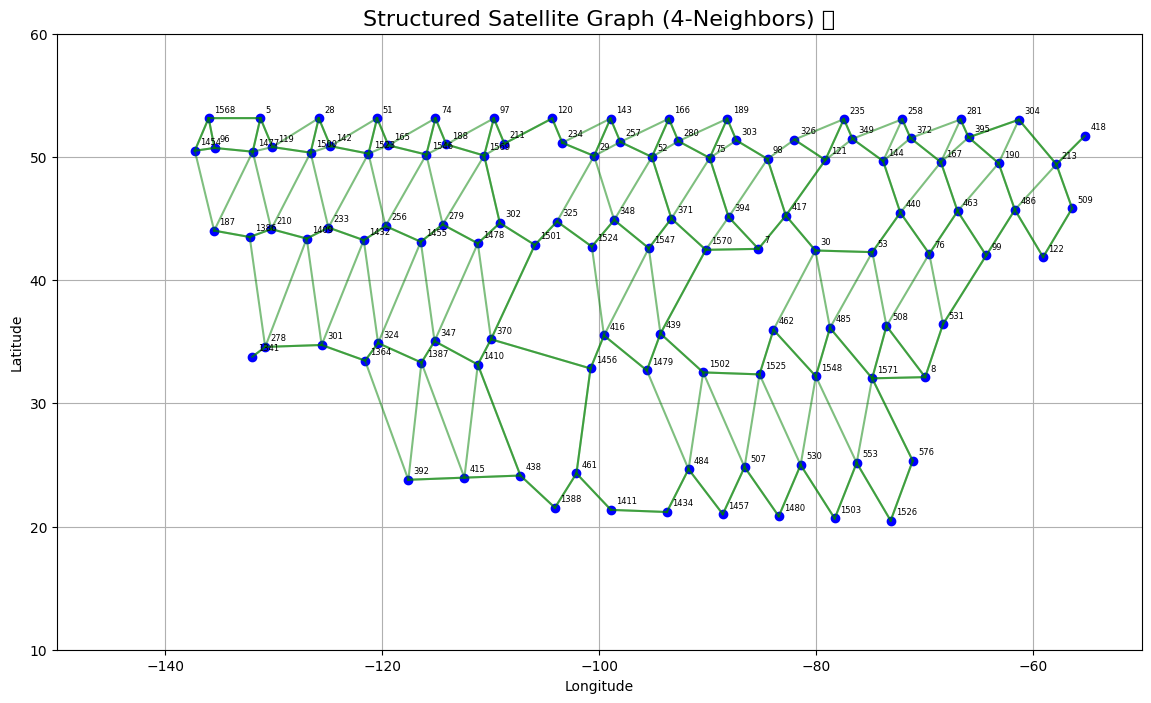

In [6]:
import matplotlib.pyplot as plt

# Step 1: Build mapping again (idx to lat/lon and idx to sat_id)
idx_to_pos = {idx: (sat['latitude'], sat['longitude']) for idx, sat in enumerate(satellites)}
idx_to_satid = {idx: sat['sat_id'] for idx, sat in enumerate(satellites)}

# Step 2: Set up plot
plt.figure(figsize=(14, 8))
plt.title("Structured Satellite Graph (4-Neighbors) 🌍", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# Step 3: Plot satellites
for idx, (lat, lon) in idx_to_pos.items():
    plt.plot(lon, lat, 'bo')  # blue dot for each satellite
    plt.text(lon + 0.5, lat + 0.5, str(idx_to_satid[idx]), fontsize=6, color='black')  # Satellite ID

# Step 4: Plot edges
for src_idx, dst_list in connections.items():
    for dst_idx in dst_list:
        lat_src, lon_src = idx_to_pos[src_idx]
        lat_dst, lon_dst = idx_to_pos[dst_idx]
        plt.plot([lon_src, lon_dst], [lat_src, lat_dst], 'g-', alpha=0.5)  # green lines for edges

# Step 5: Finishing
plt.xlim(-150, -50)
plt.ylim(10, 60)
plt.show()
